# Exploratory Data Analysis of Last.fm's Mood Tags

The Last.fm Tags dataset is a complementary dataset included as part of the Million Song Dataset. More information can be found [here](https://labrosa.ee.columbia.edu/millionsong/lastfm).

The dataset is available in several different forms including individual json files for each track as well as an sqlite db. Iterating over the json files is cumbersome, so we make use of the sqlite db here.

The goal of this workbook is to explore the tags available in the Last.fm dataset with a special focus on the moods targeted in our project.

In [17]:
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
import pandas as pd
import os

%pprint
%matplotlib inline

Pretty printing has been turned ON


# Getting Started

### Connecting to the DB

In [18]:
from label_lyrics import LASTFM_TAGS_DB
import sqlite3

dbpath = os.path.abspath(LASTFM_TAGS_DB)
print(dbpath)
conn = sqlite3.connect(dbpath)
conn

/home/jcworkma/jack/w266-group-project_lyric-mood-classification/data/lastfm_tags.db


### Example Last.fm Tags Queries

These examples are taken from the very helpful [MSD provided example code](https://labrosa.ee.columbia.edu/millionsong/sites/default/files/lastfm/demo_tags_db.py) demonstrating how to work with the last.fm sqlite db.

In [19]:
from label_lyrics import sanitize

In [20]:
print('************** DEMO 4 **************')
tag = 'Acid Smurfs'
print('We get all tracks for the tag: {0}'.format(tag))
sql = "SELECT tids.tid FROM tags, tids, tid_tag WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND tags.tag='{0}'".format(sanitize(tag))
res = conn.execute(sql)
data = res.fetchall()

pprint(data)

************** DEMO 4 **************
We get all tracks for the tag: Acid Smurfs
[('TRDATLJ128F92FC75F',),
 ('TRVTZIF128F42725C1',),
 ('TREPQOO128F9328886',),
 ('TROXKKP128F427886F',)]


In [21]:
print('************** DEMO 5 **************')
print("We get all tags and the number of tracks they're applied to")
sql = "SELECT tags.tag, COUNT(tid_tag.tid) FROM tid_tag, tags WHERE tid_tag.tag=tags.ROWID GROUP BY tags.tag"

### WARNING - this one takes a minute... uncomment these lines to execute
#res = conn.execute(sql)
#data = res.fetchall()
#data = sorted(data, key=lambda x: x[1], reverse=True)
#print('after sorting...')
#for k in range(10):
#    print(data[k])
#print('...')

************** DEMO 5 **************
We get all tags and the number of tracks they're applied to


### Last.fm DB Schema Exploration

In order to use the provided db effectively, we need to know its schema. Here we use sql commands to expose its table structure (credit: https://www.tomordonez.com/get-schema-sqlite-python.html).

It turns out that the schema is incredibly simple.


In [22]:
cur = conn.cursor()

tables = list()
for row in cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall():
    tables.append(row[0])

print('Tables: {0}\n'.format(tables))

for table in tables:
    
    cols = list()
    for row in cur.execute("pragma table_info('{0}')".format(table)).fetchall():
        cols.append(row[1])

    row_count = cur.execute("SELECT Count(*) FROM {0}".format(table)).fetchall()[0][0]
        
    print('Table "{0}"'.format(table))
    print('\tcolumns: {0}'.format(cols))
    print('\trows: {0}'.format(row_count))
    
    #print(cur.execute("SELECT * FROM {0} LIMIT 5".format(table)).fetchall())
    
cur.close()

Tables: ['tags', 'tids', 'tid_tag']

Table "tags"
	columns: ['tag']
	rows: 522366
Table "tids"
	columns: ['tid']
	rows: 505216
Table "tid_tag"
	columns: ['tid', 'tag', 'val']
	rows: 8598630


And here is a quick peek at the beginning five rows of each table.

In [23]:
for table in tables:
    
    df = pd.read_sql_query("SELECT * FROM {0} LIMIT 5".format(table), conn)
    print(df)

                tag
0      classic rock
1  Progressive rock
2             blues
3      memphis slim
4               pop
                  tid
0  TRCCCYE12903CFF0E9
1  TRCCCFH12903CEBC70
2  TRCCCJT128F429FFF6
3  TRCCCBJ128F4286E6F
4  TRCCJTI128EF35394A
   tid  tag    val
0    1    1  100.0
1    1    2  100.0
2    2    3  100.0
3    2    4  100.0
4    3    5  100.0


### Matching a Song to its Labels

With the mapping data from MusixMatch and the sqlite db from last.fm, we can tie songs to their labels.

In [24]:
example_song = {
    'msd_id': 'TRLIEDO12903CA41B4',
    'msd_artist': '10 CC',
    'msd_title': 'The Things We Do For Love',
    'mxm_id': '2258063',
    'mxm_artist': '10cc',
    'mxm_title': 'The Things We Do for Love'
}
sql = "SELECT tids.tid, tags.tag, tid_tag.val FROM tid_tag, tids, tags WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND tids.tid='{0}'".format(sanitize(example_song['msd_id']))
res = conn.execute(sql)
data = res.fetchall()
pprint(data)


[('TRLIEDO12903CA41B4', 'classic rock', 53.0),
 ('TRLIEDO12903CA41B4', 'pop', 28.0),
 ('TRLIEDO12903CA41B4', '70s', 100.0),
 ('TRLIEDO12903CA41B4', 'rock', 38.0),
 ('TRLIEDO12903CA41B4', 'favorites', 3.0),
 ('TRLIEDO12903CA41B4', 'upbeat', 2.0),
 ('TRLIEDO12903CA41B4', 'loved', 2.0),
 ('TRLIEDO12903CA41B4', 'Awesome', 2.0),
 ('TRLIEDO12903CA41B4', 'british', 4.0),
 ('TRLIEDO12903CA41B4', 'Love', 4.0),
 ('TRLIEDO12903CA41B4', 'first person songs', 1.0),
 ('TRLIEDO12903CA41B4', 'male vocalists', 5.0),
 ('TRLIEDO12903CA41B4', 'adult contemporary', 2.0),
 ('TRLIEDO12903CA41B4', 'soft rock', 33.0),
 ('TRLIEDO12903CA41B4', 'pop rock', 3.0),
 ('TRLIEDO12903CA41B4', "70's", 2.0),
 ('TRLIEDO12903CA41B4', '1970s', 2.0),
 ('TRLIEDO12903CA41B4', 'oldies', 9.0),
 ('TRLIEDO12903CA41B4', 'love songs', 6.0),
 ('TRLIEDO12903CA41B4', 'close harmony', 2.0),
 ('TRLIEDO12903CA41B4', 'acclaimed music top 3000', 2.0),
 ('TRLIEDO12903CA41B4', 'golden oldies', 3.0),
 ('TRLIEDO12903CA41B4', 'easy now', 1.0),
 (

# Tag EDA

Now that we know the schema and how to connect to and query the db, we can investigate its contents.

### Number of Tags

In [26]:
from label_lyrics import query

data = query(conn, "SELECT tag FROM tags")
print('Number of Tags:', len(data))

data = query(conn, "SELECT tag FROM tags LIMIT 10")
print('\nExample Tags:', ([x[0] for x in data]))


Number of Tags: 522366

Example Tags: ['classic rock', 'Progressive rock', 'blues', 'memphis slim', 'pop', '70s', 'Middle of the road', 'Bonjour ca va', 'Tony Levin', 'instrumental']


### Tag Count Histogram

From the following histogram, we observe, that there must be a very, very long rightward tail.

In [27]:
df = pd.read_sql_query("SELECT tags.tag, COUNT(tid_tag.tid) as count FROM tid_tag, tags WHERE tid_tag.tag=tags.ROWID GROUP BY tags.tag ORDER BY count desc", conn)

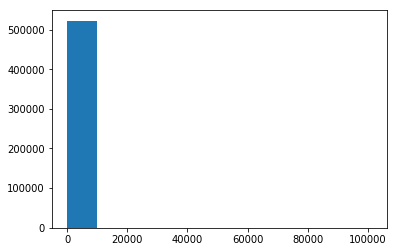

In [28]:
histodata = df
_ = plt.hist(histodata['count'])

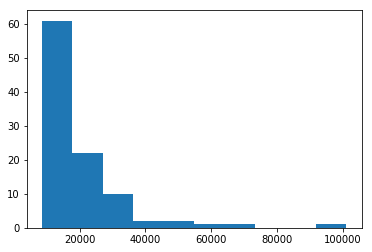

In [29]:
histodata = df.head(100)
_ = plt.hist(histodata['count'])

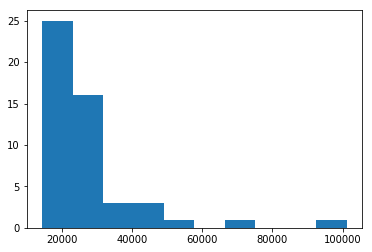

In [30]:
histodata = df.head(50)
_ = plt.hist(histodata['count'])

# Defining the Moods

### Mood Categories

The moods and categories we use are based on the mapping found in the paper ["Lyric Text Mining in Music Mood Classification"](http://www.ismir2009.ismir.net/proceedings/PS3-4.pdf).

H. Xiao, J. S. Downie, and A. F. Ehmann, “Lyric TextMining in Music Mood Classiﬁcation,” American Mu-sic, vol. 183, no. 5040, pp. 411–416, 2009



In [31]:
from label_lyrics import MOOD_CATEGORIES
print('Number of Mood Categories = {0}\n'.format(len(MOOD_CATEGORIES)))
print('Categories:\n')
pprint(MOOD_CATEGORIES)

Number of Mood Categories = 18

Categories:

{'aggression': ['aggression', 'aggressive'],
 'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
 'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'],
 'brooding': ['brooding', 'contemplative', 'meditative', 'reflective'],
 'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill out'],
 'cheerful': ['cheerful', 'cheer up', 'festive', 'jolly', 'jovial', 'merry'],
 'confident': ['confident', 'encouraging', 'encouragement', 'optimism'],
 'depressed': ['depressed', 'blue', 'dark', 'depressive', 'dreary'],
 'desire': ['desire', 'hope', 'hopeful', 'mood: hopeful'],
 'dreamy': ['dreamy'],
 'earnest': ['earnest', 'heartfelt'],
 'excitement': ['excitement', 'exciting', 'exhilarating', 'thrill', 'ardor'],
 'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'],
 'happy': ['happy', 'happiness', 'happy songs', 'happy music'],
 'pessimism': ['pessimism', 'cynical', 'pessimistic', 'weltschmerz'],
 'rom

### Expanding the Categories

The last.fm dataset is generated by users without scientific rigor in mind. There is a chance that searching for an exact match on a mood and its related moods will not always yield all possible matches. In this section, we will explore additional tags that match with each category.

For each mood, we query all tracks that match exactly with the mood and its siblings. We then query all tracks that match with LIKE the mood and its siblings with some small modifications if necessary (ex: instead of an exact match on 'meditation', we query for a LIKE match on 'meditat' to allow for different conjugations). We then manually review the returned tags and build a set of filters to remove tags that match but are not appropriate. We then run the same queries again but with those filters to find the final net impact of using LIKE rather than exact match.

In [161]:
def match_tags_to_songs(tags, conn):
    """
    Helper function to get all songs that match a group of tags
    """
    sql = ("SELECT tids.tid, tags.tag, tid_tag.val "
           "FROM tid_tag, tids, tags "
           "WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND (")
    last = len(tags)
    for i, tag in enumerate(tags):
        sql += "tags.tag='{0}' ".format(tag)
        if i + 1 != last:
            sql += 'OR '
    sql += ')'
    df = pd.read_sql_query(sql, conn)
    return df

def match_like_tags_to_songs(tags, conn):
    """
    Helper function to get all songs that match with 'LIKE' a group of tags
    """
    sql = ("SELECT tids.tid, tags.tag, tid_tag.val "
           "FROM tid_tag, tids, tags "
           "WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND (")
    last = len(tags)
    for i, tag in enumerate(tags):
        sql += "tags.tag LIKE '%{0}%' ".format(tag)
        if i + 1 != last:
            sql += 'OR '
    sql += ')'
    df = pd.read_sql_query(sql, conn)
    return df

def set_difference(pd_series1, pd_series2):
    set_diff = set(pd_series1.unique()) - set(pd_series2.unique())
    return set_diff

def filter_by_substring(df, filters):
    for filt in filters:
        df = df[~df.tag.str.lower().str.contains(filt)]
    return df

def like_match_analysis(tags, likes, conn, filters=None):
    """
    Helper function to query and then compare the difference between the two
    query methods
    """
    df_exact = match_tags_to_songs(tags, conn)
    df_like = match_like_tags_to_songs(likes, conn)
    print('Number of songs that are a direct match:', len(df_exact))
    print('Number of songs that are an approximate match:', len(df_like))
    if filters:
        df_like = filter_by_substring(df_like, filters)
        print('\tafter filter:', len(df_like))
    print('\nExample tags covered by the approximate match and not by the direct match:\n')
    set_diff = set_difference(df_like.tag, df_exact.tag)
    print(list(set_diff)[:10])
    pct_improve = -1
    if len(df_exact) > 0:
        pct_improve = len(df_like) / len(df_exact) * 100
    print('\nImprovement granted by like match: {0} songs, {1:.2f}%'.format(
        len(df_like) - len(df_exact), pct_improve))
    
    return df_exact, df_like, set_diff

#### Aggression

In [139]:
_, _, _ = like_match_analysis(MOOD_CATEGORIES['aggression'], ['aggress'], conn)

Number of songs that are a direct match: 1656
Number of songs that are an approximate match: 2428

Example tags covered by the approximate match and not by the direct match:

['Aggressive Thrash Metal', 'Post Aggressive', 'volatile aggressive', 'not so aggressive', 'softly-aggressive', 'Aggressive Singing', 'Aggressive Alternative - At work music', 'aggressiv', 'awesomely aggressive', 'chill-to-aggressive']

Improvement granted by like match: 772 songs, 146.62%


Wow! The LIKE search uncovered a lot of missing tags. However, there are some that do not fit the bill. Reviewing the above list, we see the following that should not be included as part of Aggressive. These will be manually culled.

* 'not so aggressive'
* 'aggressio'

In [140]:
_, _, _ = like_match_analysis(MOOD_CATEGORIES['aggression'], ['aggress'], conn, filters=['not so aggressive', 'aggressio'])

Number of songs that are a direct match: 1656
Number of songs that are an approximate match: 2428
	after filter: 2303

Example tags covered by the approximate match and not by the direct match:

['Aggressive Thrash Metal', 'volatile aggressive', 'Post Aggressive', 'softly-aggressive', 'Aggressive Singing', 'aggressiv', 'awesomely aggressive', 'chill-to-aggressive', 'aggressively feminine', 'melodically aggressive']

Improvement granted by like match: 647 songs, 139.07%


#### Anger

In [141]:
df_exact, df_like, set_diff = like_match_analysis(MOOD_CATEGORIES['anger'], ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'], conn)

Number of songs that are a direct match: 3158
Number of songs that are an approximate match: 21928

Example tags covered by the approximate match and not by the direct match:

['garage-psych', 'angry pop music', 'entourage soundtrack', 'i am angry', 'English Garage', 'Lone Daranger', 'swedish-garage-rock-revival', 'rage against the machine - down rodeo', 'angry break up songs', 'good when your angry']

Improvement granted by like match: 18770 songs, 694.36%


In [142]:
# we can see that there are many tags that do not fit in with 'anger'
# we attempt to filter those out here for a better look
filters = ['garage', 'entourage', 'daranger', 'danger', 'underage', 'banger',
          'ranger', 'doppleganger', 'doppelganger', 'traged', 'piangere', 'stranger',
          'beverage', 'coverage', 'zangeres', 'average', 'mirage', 'underage',
          'langer', 'not in anger', 'tanger', 'fuleragem', 'fragements', 'enouragement',
          'suffragette', 'avarage', 'leverage', 'changer', 'courage', 'hervorragend', 
          'bursdagsanger', 'tragedies', 'rage against the machine', 'volkzangers',
          'getragen', 'frageze', 'tanger', 'arragem', 'not rage', 'wangerFamilie',
          'cooperage', 'anchorage', 'sanger', 'manger', 'sangerin', 'kenneth anger',
          'svanger', 'songs that take all the anger out of you', 'pandeiragem', 'behangers',
          'fragen', 'angerls', 'frage', 'korageklimper', 'sjanger', 'umbrageous']

df_exact, df_like, set_diff = like_match_analysis(MOOD_CATEGORIES['anger'], ['anger', 'angry', 'choleric', 'fury', 'outrage', 'rage'], conn, filters=filters)

Number of songs that are a direct match: 3158
Number of songs that are an approximate match: 21928
	after filter: 5968

Example tags covered by the approximate match and not by the direct match:

['angry donald duck metal', 'songs better than dont look back in anger', 'angry pop music', 'i am angry', 'angry break up songs', 'good when your angry', 'videos I loved on rage when I was a kid', 'angry muzak', 'Sound and Fury', 'it is hard to be angry while listening to this']

Improvement granted by like match: 2810 songs, 188.98%


#### Angst

In [143]:
df_exact, df_like, set_diff = like_match_analysis(MOOD_CATEGORIES['angst'], ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'], conn)    

Number of songs that are a direct match: 1213
Number of songs that are an approximate match: 5488

Example tags covered by the approximate match and not by the direct match:

['im tense and nervous', 'angstyish', 'electronic angst', 'angstt', 'existential angst', 'chill gangsta tunes', 'gangsta shit g-unit', 'Gangsta free zone', 'Nervous Records', 'hardcore gangster rap']

Improvement granted by like match: 4275 songs, 452.43%


In [144]:
filters = ['gangst', 'langstrumpf', 'farangstar', 'gaaangstaa', 'klangstark', ]

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['angst'],
    ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'],
    conn,
    filters=filters)    

Number of songs that are a direct match: 1213
Number of songs that are an approximate match: 5488
	after filter: 1912

Example tags covered by the approximate match and not by the direct match:

['tense-anxious love-ache heart-sex song', 'im tense and nervous', 'the word nervous', 'angsti', 'angstyish', 'existential angst', 'angstt', 'electronic angst', 'Nervous Records', 'too angsty for a tuesday']

Improvement granted by like match: 699 songs, 157.63%


#### Brooding

In [145]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['brooding'],
    ['brood', 'contemplat', 'meditat', 'reflect'],
    conn)    

Number of songs that are a direct match: 1360
Number of songs that are an approximate match: 5443

Example tags covered by the approximate match and not by the direct match:

['reflective funk', 'seashore meditation', 'self reflection being drowned in a bathtub', 'Reflections of me', 'music for contemplation', 'Silverchair-Reflections of a sound', 'Marilyn Manson - The Reflecting God', 'music is meditation', 'meditative funk', 'premeditated pleasures']

Improvement granted by like match: 4083 songs, 400.22%


In [151]:
filters = ['broodcast', 'marilyn manson - the reflecting god', 'silverchair-reflections of a sound']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['brooding'],
    ['brood', 'contemplat', 'meditat', 'reflect'],
    conn,
    filters=filters)   

Number of songs that are a direct match: 1360
Number of songs that are an approximate match: 5443
	after filter: 5439

Example tags covered by the approximate match and not by the direct match:

['reflective funk', 'seashore meditation', 'self reflection being drowned in a bathtub', 'Reflections of me', 'music for contemplation', 'music is meditation', 'meditative funk', 'premeditated pleasures', 'post-rock contemplative', 'self reflection']

Improvement granted by like match: 4079 songs, 399.93%


#### Calm (TODO!!!)

In [153]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['calm'],
    ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill'],
    conn)   

Number of songs that are a direct match: 10785
Number of songs that are an approximate match: 142518

Example tags covered by the approximate match and not by the direct match:

['chillout to check out', 'serenes it up', 'takin a chill pill', 'progressive chill', 'David design From Sweden with Love and mellow voices', 'soundtrack quiet', 'chillstrumental', 'chill bossa', 'chillout dnb', 'Norwegian Chillout']

Improvement granted by like match: 131733 songs, 1321.45%


In [ ]:
filters = []

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['calm'],
    ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill'],
    conn,
    filters=filters)

#### Cheerful (TODO!)

In [152]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['cheerful'],
    ['cheer', 'festive', 'jolly', 'jovial', 'merry'],
    conn)   

Number of songs that are a direct match: 1395
Number of songs that are an approximate match: 4920

Example tags covered by the approximate match and not by the direct match:

['the hipster guide to a very merry christmas', 'cheerful 9', 'hey cheer up i love you', 'bizarre cheerleader rock-hop', 'samples jolly roger by adam and the ants', 'happy and cheerful', 'Rosemary Clooney Merry Xmas', 'merry-go-round', 'merry metal', 'Merry Christmas']

Improvement granted by like match: 3525 songs, 352.69%


#### Confident (TODO!)

In [154]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['confident'],
    ['confident', 'encouraging', 'encouragement', 'optimism'],
    conn)   

Number of songs that are a direct match: 247
Number of songs that are an approximate match: 553

Example tags covered by the approximate match and not by the direct match:

['Awesome Encouragement', 'unbridled optimism', 'Foggy Optimism', 'Creative Encouragement', 'Doctor Who Confidential', 'High School Confidential', 'this is like some sort of LA confidential-esque chase scene but in space or something', 'what a dark optimism', 'optimism as irony', '80s confident']

Improvement granted by like match: 306 songs, 223.89%


#### Depressed (TODO!)

In [156]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['depressed'],
    ['depress', 'blue', 'dark', 'dreary'],
    conn)   

Number of songs that are a direct match: 9522
Number of songs that are an approximate match: 134462

Example tags covered by the approximate match and not by the direct match:

['bbbluesclub', 'depressiv black metal', 'Slow Burn Blues', 'dark and female', 'post blue-core rock', 'darkling', 'finnish blues', 'Dark Classic', 'eiris-bluenile', 'dark synths']

Improvement granted by like match: 124940 songs, 1412.12%


#### Desire

In [175]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['desire'],
    ['desire', 'desirin', 'hope', 'hopin'],
    conn)   

Number of songs that are a direct match: 576
Number of songs that are an approximate match: 2850

Example tags covered by the approximate match and not by the direct match:

['hope tinged with melancholy', 'Naieela Hope of the States mix', 'hopelorn', 'you hope that he get what he deservesa', 'desire music', 'Trip-HopElectronicJazzExperimentalNorwegianIdmNu JazzNu-JazzAcid JazzDowntempoChillout', 'gives me hope for rap music', 'always hope that we die holding hands', 'miridesire', 'hope for the hopeless']

Improvement granted by like match: 2274 songs, 494.79%


In [183]:
filters = ['hope of the states mix', 'hopelorn', 'you hope that he get what', 'trip-hop', 'hope sandoval',
          'hopeless', 'swallow the sun', 'trip hop', 'hopelessness', 'chopin', 'the white ship of hope', 'no hope',
          'hope is gone', 'hopeton', 'hip-hope', 'james hope', 'hoperas', 'randy hope', 'falsehope', 'i hope not',
          'rapid hope loss', 'hopek', 'give up all hope', 'barbershopesque', 'miridesire', 'i hope my neighbour',
          'pirates of the caribbean']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['desire'],
    ['desire', 'desirin', 'hope', 'hopin'],
    conn,
    filters=filters)

Number of songs that are a direct match: 576
Number of songs that are an approximate match: 2850
	after filter: 2350

Example tags covered by the approximate match and not by the direct match:

['hope tinged with melancholy', 'desire music', 'gives me hope for rap music', 'always hope that we die holding hands', 'hope for america', 'hopeful lyrics', 'withered hope', 'hope and desire', 'With hope', 'Prayer Hope Faith God']

Improvement granted by like match: 1774 songs, 407.99%


#### Dreamy

In [162]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['dreamy'],
    ['dreamy'],
    conn)

Number of songs that are a direct match: 0
Number of songs that are an approximate match: 7487

Example tags covered by the approximate match and not by the direct match:

['dreamy melancholy', 'Dreamy Mind', 'dreamy goodness', 'dreamy shoegazer', 'dreamy hip hop', 'dreamyGrooves', 'dreamy sun', 'dreamy mix', 'dreamy-drifty-floaty goodness', 'dreamy post-punk']

Improvement granted by like match: 7487 songs, -1.00%


In [186]:
filters = ['wasnt jake dreamy', 'val kilmer is dreamy', 'alex james', 'roots manuva']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['dreamy'],
    ['dreamy'],
    conn,
    filters=filters)

Number of songs that are a direct match: 0
Number of songs that are an approximate match: 7487
	after filter: 7480

Example tags covered by the approximate match and not by the direct match:

['dreamy melancholy', 'Dreamy Mind', 'dreamy goodness', 'dreamy shoegazer', 'dreamy hip hop', 'dreamyGrooves', 'dreamy sun', 'dreamy mix', 'dreamy-drifty-floaty goodness', 'dreamy post-punk']

Improvement granted by like match: 7480 songs, -1.00%


#### Earnest

In [164]:
# extra synonyms gathered from google "earnest synonyms"
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['earnest'],
    ['earnest', 'heartfelt'] + ['devout', 'wholeheart', 'sincere', 'impassion', 'fervent', 'ardent'],
    conn)   

Number of songs that are a direct match: 509
Number of songs that are an approximate match: 923

Example tags covered by the approximate match and not by the direct match:

['french earnest sentimental', 'fervent qawwali', 'those songs that take you back in a way that is sincerely frightening', 'importance of being earnest', 'impassioned', 'seems to be passionate but not sincere', 'heartfelt vocals', 'i know my sentimental earnestness is not so much in fashion', 'just what made our encounters so sincere', 'Sincerely Me von  New Found Glory']

Improvement granted by like match: 414 songs, 181.34%


In [190]:
filters = ['fervent qawwali', 'sincerely frightening', 'not sincere', 'sincere mj cole nero rmx',
          'brand nubian', 'i would clap', 'insincere', 'monneglows', 'sri radha', 'new found glory']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['earnest'],
    ['earnest', 'heartfelt'] + ['devout', 'wholeheart', 'sincere', 'impassion', 'fervent', 'ardent'],
    conn,
    filters=filters)


Number of songs that are a direct match: 509
Number of songs that are an approximate match: 923
	after filter: 898

Example tags covered by the approximate match and not by the direct match:

['french earnest sentimental', 'importance of being earnest', 'impassioned', 'heartfelt soul', 'heartfelt vocals', 'i know my sentimental earnestness is not so much in fashion', 'just what made our encounters so sincere', 'heartfelt sing out loud', 'heartfelted wrenching and stangulation of emotions', 'sounds so sincere I could die']

Improvement granted by like match: 389 songs, 176.42%


#### Excitement (TODO!)

In [165]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['excitement'],
    ['excite', 'exhilarating', 'thrill', 'ardor'],
    conn)   

Number of songs that are a direct match: 532
Number of songs that are an approximate match: 1071

Example tags covered by the approximate match and not by the direct match:

['thriller-fall out boy', 'you re my thrill', 'No cheap thrill', 'The Thrilla - Juat Travelling Through', 'thrillseekers-super ambient', 'thriller', 'so excited', 'orchestral-thriller', 'songs that excite me', 'pretend this is thriller']

Improvement granted by like match: 539 songs, 201.32%


In [196]:
filters = ['juat travelling through', 'tardor', 'excited for full album', 'michael jackson', 'richardor',
          'thrilla riddim', 'hardore', 'the pointer sisters']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['excitement'],
    ['excite', 'exhilarating', 'thrill', 'ardor'],
    conn,
    filters=filters)


Number of songs that are a direct match: 532
Number of songs that are an approximate match: 1071
	after filter: 1051

Example tags covered by the approximate match and not by the direct match:

['Thrillseekers-escape', 'thriller-fall out boy', 'you re my thrill', 'thrill is gone', 'orange juice - simply thrilled honey', 'No cheap thrill', 'makes me excited', 'ThrillerLily', 'thrillseekers-super ambient', 'thriller']

Improvement granted by like match: 519 songs, 197.56%


#### Grief (TODO!)

In [166]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['grief'],
    ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'],
    conn)   

Number of songs that are a direct match: 1909
Number of songs that are an approximate match: 4896

Example tags covered by the approximate match and not by the direct match:

['johnny cashjohnny thunders and the heartbreakers', 'christmas heartbreak', 'elegance and heartbreak', 'In sorrow not in anger', 'the real heartbreaking ones', 'tom petty and the heartbreakers', 'sorrowed heart of sadness', 'mournful guitar', 'tom petty and the heartbreakers - born in chicago preformed live at soundstage', 'the dawn before heartbreak']

Improvement granted by like match: 2987 songs, 256.47%


#### Happy (TODO!)

In [167]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['happy'],
    ['happy', 'happiness', 'happy songs', 'happy music', 'happ'],
    conn)   

Number of songs that are a direct match: 13069
Number of songs that are an approximate match: 29439

Example tags covered by the approximate match and not by the direct match:

['All Happniess', 'happy alternative', 'happy hippy', 'This song just so happens to be by Wilco', 'chill happy', 'Get happy along the way', 'warm soulful and happy', 'Wake-Up-And-Be-Happy-Music', 'happy as we can be', 'happy or happyish travis']

Improvement granted by like match: 16370 songs, 225.26%


#### Pessimism (TODO!)

In [168]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['pessimism'],
    ['pessimis', 'cynic', 'weltschmerz'],
    conn)   

Number of songs that are a direct match: 37
Number of songs that are an approximate match: 982

Example tags covered by the approximate match and not by the direct match:

['cynical lovesong', 'cynical/sarcastic', 'pessimismo e fastidio', 'the sound of my cynicism melting', 'pessimism can be so pretty', 'i am too cynical to say i dont give a fuck', 'mood: pessimistic', 'For a pessimist', 'Music to feed my inner Pessimist', 'cynic']

Improvement granted by like match: 945 songs, 2654.05%


#### Romantic (TODO!)

In [169]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['romantic'],
    ['romant'],
    conn)   

Number of songs that are a direct match: 9448
Number of songs that are an approximate match: 18283

Example tags covered by the approximate match and not by the direct match:

['slow romantic song', 'dead romantic', 'mi musica romantica alegre', 'romantic instrumental', 'romantic pop', 'romantic night', 'Dark Romanticism', 'romantic tension', 'Romantic lovesongs', 'downtempo electronic chill romantic']

Improvement granted by like match: 8835 songs, 193.51%


#### Sad (TODO!)

In [170]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['sad'],
    ['sad', 'unhapp', 'melanchol'],
    conn)   

Number of songs that are a direct match: 21115
Number of songs that are an approximate match: 49105

Example tags covered by the approximate match and not by the direct match:

['revived melancholy', 'Soul-achingly sad', 'Sad but good songs', 'Beautiful sadness', 'melancholic mood', 'fck melancholy', 'melancholy on the edge of apocalypse', 'sad slow and sleepy', 'sadindie', 'make me sad']

Improvement granted by like match: 27990 songs, 232.56%


#### Upbeat (TODO!)

In [172]:
df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['upbeat'],
    ['upbeat', 'gleeful', 'high spirits', 'zest', 'enthusias'],
    conn)   

Number of songs that are a direct match: 9569
Number of songs that are an approximate match: 11570

Example tags covered by the approximate match and not by the direct match:

['upbeat dance 80s', 'upbeat instrumental', 'zestcooooooool :D', 'upbeat  holiday', 'female upbeat', 'upbeatpounder', 'upbeat Xmas', 'overlooked for its musical value due to its upbeat nature', 'upbeatsweetsound', 'lovely upbeat']

Improvement granted by like match: 2001 songs, 120.91%


### Category Breakdown For '1' Artists

In [50]:
import index_lyrics
#reload(index_lyrics)

In [44]:
from scrape_lyrics import make_lyric_file_name
from etl_lyrics import read_file_contents
import os

data_path = 'data/lyrics/json'
for lyric_file in os.listdir(data_path):
    if lyric_file.startswith('1'):
        lyric_file = os.path.join(data_path, lyric_file)
        print(lyric_file)
        lyrics_json = read_file_contents(lyric_file, read_json=True)
        pprint(lyric_json)
        break

data/lyrics/json\10000_Maniacs___Across_The_Fields.json
{'artist': '10,000 Maniacs',
 'songs': [{'album': 'Love Among the Ruins',
            'artist': '10,000 Maniacs',
            'image': 'https://images.genius.com/7e0d355bb260be0939dc6e840a6e031f.1000x1000x1.jpg',
            'json': {'album': {'api_path': '/albums/119947',
                               'artist': {'api_path': '/artists/329672',
                                          'header_image_url': 'https://images.genius.com/19bce682233adf201461879d086f844b.450x294x1.jpg',
                                          'id': 329672,
                                          'image_url': 'https://images.genius.com/d1719d6fec954289d9e067a2929ba69e.640x420x1.jpg',
                                          'is_meme_verified': False,
                                          'is_verified': False,
                                          'name': '10,000 Maniacs',
                                          'url': 'https://genius.com/ar